In [137]:
import sys
sys.path.append('../')
from unicodedata import name
from models.models import Conv_Diff, GradCAM
import json
import h5py
import ast
import numpy as np
import spectral
from spectral import imshow
from PIL import Image
spectral.settings.envi_support_nonlowercase_params = True
from dataloaders.dataloaders import dataset_iron_balanced_mixed
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data  import random_split
from trainer import train_regression
from configs.training_cfg import *
import torch
import random
import os
import openpyxl

torch.autograd.set_detect_anomaly(True)
pool = torch.nn.AvgPool2d(3,3)
mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

In [138]:
def z_score_normalization(wave):
    # 计算均值和标准差
    mean_value = np.mean(wave)
    std_value = np.std(wave)
    # 按照公式进行归一化
    wave_normalized = (wave - mean_value) / std_value
    # 返回归一化后的张量
    return wave_normalized

# 定义一个最大最小归一化的函数
def min_max_normalization(wave):
    # 计算最大值和最小值
    max_value = np.max(wave)
    min_value = np.min(wave)
    # 按照公式进行归一化
    wave_normalized = (wave - min_value) / (max_value - min_value)
    # 返回归一化后的张量
    return wave_normalized

In [139]:
torch.autograd.set_detect_anomaly(True)
mask_rgb_values = [[255,242,0],[34,177,76],[255,0,88]]

def test_data(list, pool_size=3):
    pool = torch.nn.AvgPool2d(pool_size, pool_size)
    test_data_list = []
    for id in list:
        pixel_list = []
        imgid, sampleid = id.split('_')
        sampleid = ord(sampleid) - 65
        img_data = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid))
        gt = ast.literal_eval(img_data.metadata['gt_TFe'])
        img_data = torch.Tensor(img_data.asarray()/6000)[:,:,:]
        img_data = pool(img_data.permute(2,0,1)).permute(1,2,0)
        mask = np.array(Image.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr_mask.png".format(imgid)))
        mask = pool(torch.tensor(mask, dtype=float).permute(2,0,1)).permute(1,2,0)
        print(img_data.shape)
        row, col, _ = img_data.shape
        for r in range(row):
            for c in range(col):
                if mask[r,c].tolist() == mask_rgb_values[sampleid]:
                    pixel_list.append(img_data[r,c].unsqueeze(0))

        pixel_list = torch.cat(pixel_list, dim=0)
        test_data_list.append({
            "tensor": pixel_list.to(device),
            "gt": torch.Tensor([gt[sampleid]]).to(device)
        })
    return test_data_list


In [174]:
# all dataset
all_samples = ['13_A']
all_samples = ['12_A']
all_samples = ['11_C']
all_samples = ['56_B']
all_samples = ['36_B']
all_samples = ['3_B']
# all_samples = ['32_A']
# all_samples = ['52_B']
# all_samples = ['7_B']
# all_samples = ['58_B']
# all_samples = ['3_A']
# all_samples = ['11_B']
# all_samples = ['8_C']
# all_samples = ['37_A']
# all_samples = ['61_A']


pt_path_list = ['D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold0_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold1_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold2_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold3_step100000.pt',
                'D:\\source\\repos\\Pixel-wise-hyperspectral-feature-classification-experiment\\ckpt\\1e-4_0.93_1000_1e-7\\fold4_step100000.pt']

data = []
for id in all_samples:
    imgid, sampleid = id.split('_')
    sampleid = ord(sampleid) - 65
    metadata = spectral.envi.open(dataset_path+"/spectral_data/{}-Radiance From Raw Data-Reflectance from Radiance Data and Measured Reference Spectrum.bip.hdr".format(imgid)).metadata
    gt = ast.literal_eval(metadata['gt_TFe'])
    data.append({
        "id": id,
        "gt": torch.Tensor([gt[sampleid]]).to(device)
    })

# 排序数据集
data = sorted(data, key=lambda x: x["gt"])
all_ids = [d["id"] for d in data]
all_gts = [d["gt"] for d in data]
max_gt = max(all_gts)
min_gt = min(all_gts)

# split data into 5 folds, make each fold has the same distribution
folds = [[],[],[],[],[]]
for i in range(len(data)):
    folds[i%5].append(data[i]["id"])


# 加载数据
data_tensor = test_data(all_ids, 3)

# 加载模型
models = [Conv_Diff().to(device) for i in range(5)]
for i in range(5):
    models[i].load_state_dict(torch.load(pt_path_list[i]))
    models[i].eval()

gradcams = [GradCAM(model) for model in models]

torch.Size([178, 106, 168])


c:\ProgramData\Miniconda3\envs\SI-NET\lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor([[0.1820]], device='cuda:0', grad_fn=<ClampBackward1>)


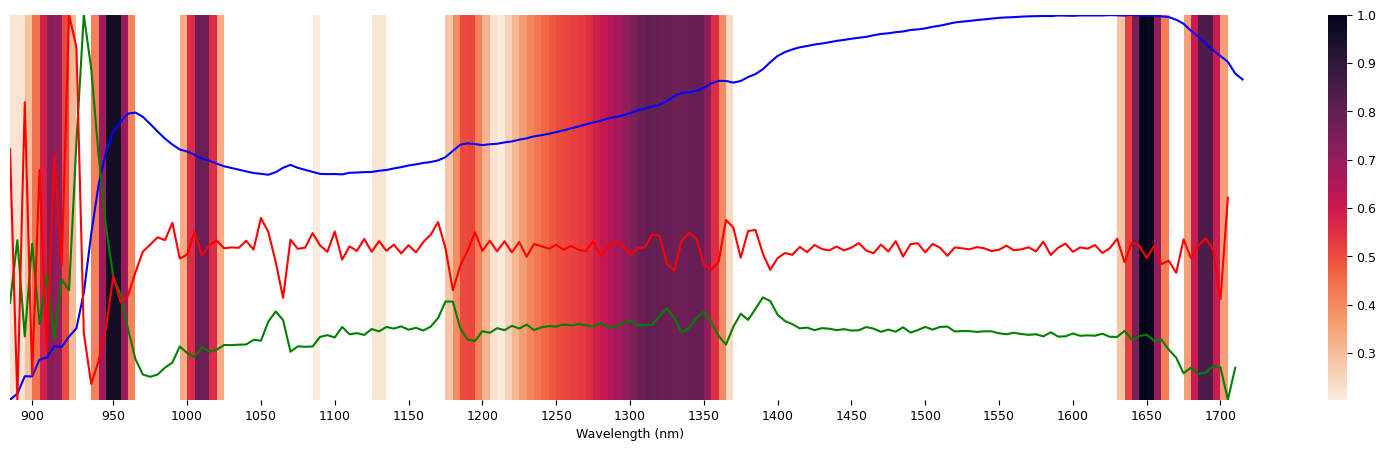

In [217]:


idx = random.randint(0,data_tensor[0]['tensor'].shape[0]-1)

cam, output = gradcams[0](data_tensor[0]['tensor'][idx].unsqueeze(0))

cam = cam.squeeze(0).squeeze(0)


fig = plt.figure(figsize=(20, 5))

x_values = np.array([886.49, 891.36, 896.22, 901.09, 905.96, 910.83, 915.7, 920.57, 925.44, 930.32, 935.19, 
                     940.07, 944.95, 949.83, 954.71, 959.6, 964.48, 969.37, 974.26, 979.15, 984.04, 988.93, 
                     993.82, 998.72, 1003.62, 1008.51, 1013.41, 1018.32, 1023.22, 1028.12, 1033.03, 1037.93, 
                     1042.84, 1047.75, 1052.66, 1057.58, 1062.49, 1067.41, 1072.32, 1077.24, 1082.16, 1087.08, 
                     1092.01, 1096.93, 1101.86, 1106.79, 1111.71, 1116.64, 1121.58, 1126.51, 1131.44, 1136.38, 
                     1141.32, 1146.26, 1151.2, 1156.14, 1161.08, 1166.03, 1170.97, 1175.92, 1180.87, 1185.82, 
                     1190.77, 1195.73, 1200.68, 1205.64, 1210.6, 1215.56, 1220.52, 1225.48, 1230.44, 1235.41, 
                     1240.38, 1245.34, 1250.31, 1255.29, 1260.26, 1265.23, 1270.21, 1275.18, 1280.16, 1285.14, 
                     1290.12, 1295.11, 1300.09, 1305.08, 1310.06, 1315.05, 1320.04, 1325.03, 1330.03, 1335.02, 
                     1340.02, 1345.01, 1350.01, 1355.01, 1360.01, 1365.02, 1370.02, 1375.03, 1380.04, 1385.05, 
                     1390.06, 1395.07, 1400.08, 1405.1, 1410.11, 1415.13, 1420.15, 1425.17, 1430.19, 1435.22, 
                     1440.24, 1445.27, 1450.29, 1455.32, 1460.35, 1465.39, 1470.42, 1475.46, 1480.49, 1485.53, 
                     1490.57, 1495.61, 1500.65, 1505.7, 1510.74, 1515.79, 1520.84, 1525.89, 1530.94, 1535.99, 
                     1541.05, 1546.1, 1551.16, 1556.22, 1561.28, 1566.34, 1571.4, 1576.47, 1581.53, 1586.6, 
                     1591.67, 1596.74, 1601.81, 1606.88, 1611.96, 1617.03, 1622.11, 1627.19, 1632.27, 1637.35, 
                     1642.43, 1647.52, 1652.61, 1657.69, 1662.78, 1667.87, 1672.96, 1678.06, 1683.15, 1688.25, 
                     1693.35, 1698.45, 1703.55, 1708.65, 1713.75, 1718.86])

heatmap_data = cam.unsqueeze(0).cpu().detach().numpy()
heatmap_data[heatmap_data < 0.2] = 0  # 将部分数据设置为0，以便后面可以显示为透明
mask = heatmap_data == 0

sns.heatmap(heatmap_data, mask=mask, cmap='rocket_r')

spec_data = data_tensor[0]['tensor'][idx].unsqueeze(0).squeeze(0).cpu().detach().numpy()
spec_data_diff1 = min_max_normalization(z_score_normalization(np.diff(spec_data, 1, axis=0)))
spec_data_diff2 = min_max_normalization(z_score_normalization(np.diff(spec_data, 2, axis=0)))
spec_data = min_max_normalization(z_score_normalization(spec_data))



# 添加曲线图
plt.plot(spec_data, color='blue', linewidth=1.5)
plt.plot(spec_data_diff1, color='green', linewidth=1.5)
plt.plot(spec_data_diff2, color='red', linewidth=1.5)

ticks = []
labels = []
cur_band = 900 # 第一个整百波长
for idx in range(x_values.__len__()):
    if x_values[idx] >= cur_band:
        ticks.append(idx)
        labels.append(str(cur_band))
        cur_band += 50
    else:
        continue


# 设置x轴的标签
plt.xticks(ticks, labels, rotation='horizontal')  # 添加 rotation='horizontal' 使得x轴标签水平显示

# 添加x轴的单位
plt.xlabel('Wavelength (nm)')  # 添加x轴的单位

# 清除y轴的标签
plt.yticks([])  # 清除y轴的标签


# 显示图表
plt.show()

# 保存图表，文件名称为{}.png, 其中{}为output保留3位小数的字符串
fig.savefig('可视化波段_赤铁矿/{}.png'.format(round(output, 5)), dpi=300, bbox_inches='tight')


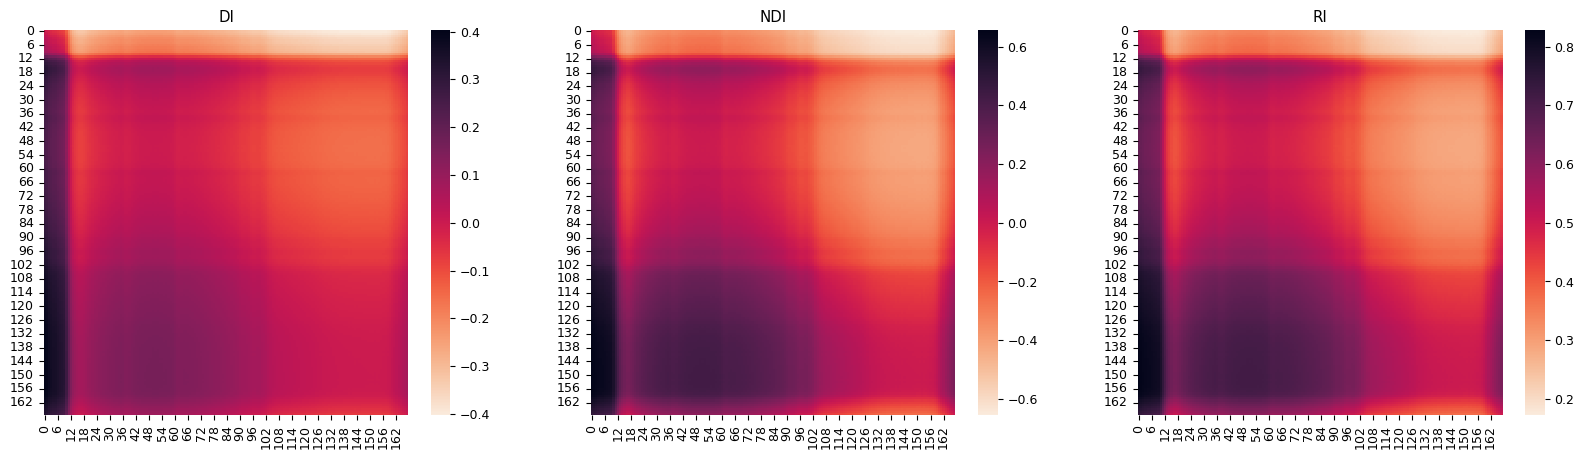

In [218]:
x2 = data_tensor[0]['tensor'][idx].unsqueeze(0).squeeze(0).cpu().detach()

DI = x2.unsqueeze(0)-x2.unsqueeze(1)
NDI = (x2.unsqueeze(0)-x2.unsqueeze(1))/(x2.unsqueeze(0)+x2.unsqueeze(1)+1e-5)
RI = x2.unsqueeze(0)/(x2.unsqueeze(1)+x2.unsqueeze(0)+1e-5) 

# 把DI, NDI, RI作为热图显示出来
fig = plt.figure(figsize=(20, 5))

# 添加DI的热图
plt.subplot(1, 3, 1)
sns.heatmap(DI.squeeze(0).cpu().detach().numpy(), cmap='rocket_r')
plt.title('DI')

# 添加NDI的热图
plt.subplot(1, 3, 2)
sns.heatmap(NDI.squeeze(0).cpu().detach().numpy(), cmap='rocket_r')
plt.title('NDI')

# 添加RI的热图
plt.subplot(1, 3, 3)
sns.heatmap(RI.squeeze(0).cpu().detach().numpy(), cmap='rocket_r')
plt.title('RI')

# 显示图表
plt.show()

# 保存图表，文件名称为{}.png, 其中{}为output保留3位小数的字符串
fig.savefig('可视化指数_赤铁矿/{}.png'.format(round(output, 3)), dpi=300, bbox_inches='tight')


In [219]:
DI.shape

torch.Size([168, 168])